# Quantum GANs: The Patch Method

## Module Imports

In [1]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Data

In [2]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, digit_path, label_path, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.digit = torch.tensor(
            (255 - np.load(digit_path)) / 255
        ).to(torch.float32)
        self.label = torch.tensor(np.load(label_path)).to(torch.int64)
        self.onehot = F.one_hot(self.label)

        self.length = len(self.digit)
        self.transform = transform

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = self.digit[idx, :, :]

        if self.transform:
            image = self.transform(image)
        
        label = self.onehot[idx, :]

        # Return image and label
        return image, label

In [3]:
image_size = 256  # Height / width of the square images
label_size = 10  # 0 ~ 9 one-hot vector
batch_size = 1

transform = transforms.Compose([])

dataset = DigitsDataset(digit_path="data/digit_256.npy", 
                        label_path='data/label_256.npy',
                        transform=transform)

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

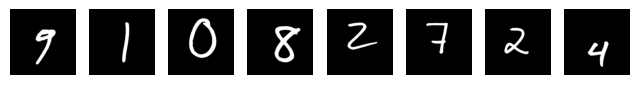

In [4]:
plt.figure(figsize=(8,2))

for i, idx in enumerate(random.sample(range(len(dataset)), 8)):
    image = dataset[idx][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

## Implementing the Discriminator

In [5]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(image_size * image_size + label_size, 64),
            nn.ReLU(),

            nn.Linear(64, 16),
            nn.ReLU(),

            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        return self.model(torch.cat([x, y], dim=1))

## Implementing the Generator

In [6]:
# Quantum variables
n_qubits = 10  # Total number of qubits / N
n_a_qubits = 0  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 64  # Number of subgenerators for the patch method / N_G

In [7]:
# Quantum simulator
# dev = qml.device("lightning.gpu", wires=n_qubits, batch_obs=True)
dev = qml.device("lightning.gpu", wires=n_qubits)

# Enable CUDA device if available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')

In [8]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

In [9]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x, y):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # apply condition to noise
        x = x * (0.6 * y + 0.2)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:
            
            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)
            
        return images

## Training

In [10]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

In [11]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

while True:
    for i, (data, label) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        label = label.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise, label)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data, label).view(-1)
        outD_fake = discriminator(fake_data.detach(), label).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data, label).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1

        # Show loss values
        print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
        if counter % 10 == 0:
            # Save images every 10 iterations
            noise = fixed_noise[0, :]
            label = torch.eye(10).to(device)
            test_images = [
                generator(noise, label[i:i+1,:]).view(image_size,image_size).cpu().detach()
                for i in range(10)
            ]
            results.append(test_images)
            
        if counter == num_iter:
            break
    if counter == num_iter:
        break

Iteration: 1, Discriminator Loss: 1.401, Generator Loss: 0.611
Iteration: 2, Discriminator Loss: 1.393, Generator Loss: 0.615
Iteration: 3, Discriminator Loss: 1.373, Generator Loss: 0.626
Iteration: 4, Discriminator Loss: 1.345, Generator Loss: 0.633
Iteration: 5, Discriminator Loss: 1.346, Generator Loss: 0.643
Iteration: 6, Discriminator Loss: 1.344, Generator Loss: 0.653
Iteration: 7, Discriminator Loss: 1.306, Generator Loss: 0.667
Iteration: 8, Discriminator Loss: 1.290, Generator Loss: 0.682
Iteration: 9, Discriminator Loss: 1.271, Generator Loss: 0.698
Iteration: 10, Discriminator Loss: 1.262, Generator Loss: 0.711
Iteration: 11, Discriminator Loss: 1.228, Generator Loss: 0.726
Iteration: 12, Discriminator Loss: 1.181, Generator Loss: 0.753
Iteration: 13, Discriminator Loss: 1.132, Generator Loss: 0.781
Iteration: 14, Discriminator Loss: 1.125, Generator Loss: 0.791
Iteration: 15, Discriminator Loss: 1.074, Generator Loss: 0.795
Iteration: 16, Discriminator Loss: 1.016, Generat

KeyboardInterrupt: 

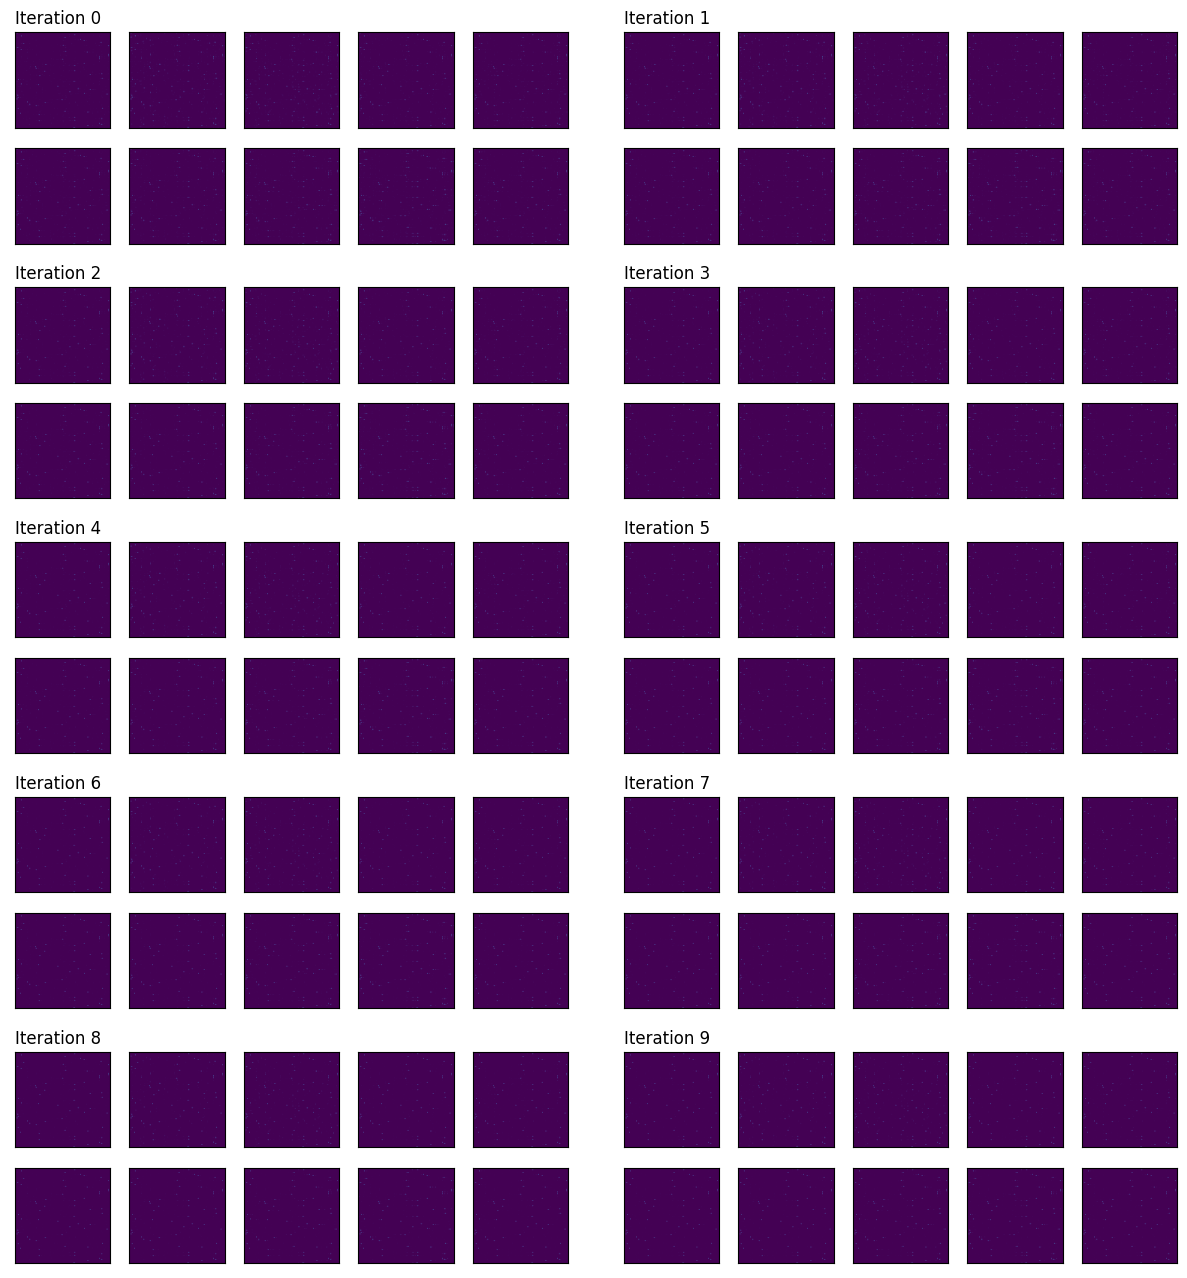

In [16]:
fig = plt.figure(figsize=(15, 16))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results[-10:]):
    inner = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=outer[i])

    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy())
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {i}', loc='left')
        fig.add_subplot(ax)

plt.show()

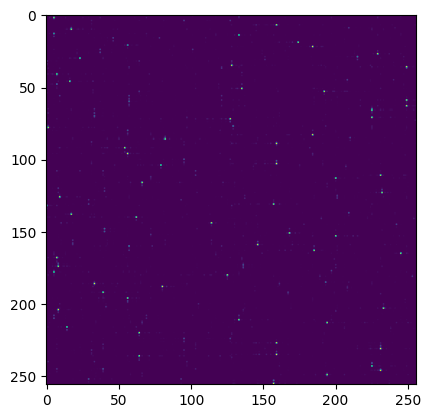

In [19]:
plt.imshow(results[-1][1])